In [1]:
import zipfile
import os

# --- 1. Define Your File Paths ---
# !!! IMPORTANT: Change this to the exact name of your uploaded zip file
zip_file_path = '/content/UAV Small Object Detection Dataset.zip'
extract_directory = 'dataset_small object'

# --- 2. Create the Directory to Extract To ---
if not os.path.exists(extract_directory):
    os.makedirs(extract_directory)

# --- 3. Unzip the File ---
try:
    print(f"Unzipping {zip_file_path}...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_directory)

    print("Unzipping complete!")
    print(f"Files extracted to: /content/{extract_directory}")

except FileNotFoundError:
    print(f"--- ERROR ---")
    print(f"File not found: {zip_file_path}")
    print("Please make sure you have uploaded the file and the name matches exactly.")
    print("You can check the file panel on the left side of Colab.")

Unzipping /content/UAV Small Object Detection Dataset.zip...
Unzipping complete!
Files extracted to: /content/dataset_small object


In [2]:
# The quotes "" are the important part!
!ls -R "/content/dataset_small object"

'/content/dataset_small object':
test_annots  train_annots  valid_annots
test_images  train_images  valid_images

'/content/dataset_small object/test_annots':
104.xml  185.xml  242.xml  30.xml   412.xml  601.xml  689.xml  76.xml	85.xml
121.xml  18.xml   246.xml  313.xml  486.xml  616.xml  699.xml  779.xml	88.xml
123.xml  193.xml  282.xml  324.xml  489.xml  642.xml  722.xml  782.xml	8.xml
126.xml  201.xml  301.xml  352.xml  512.xml  643.xml  742.xml  783.xml
128.xml  227.xml  304.xml  355.xml  565.xml  654.xml  746.xml  828.xml

'/content/dataset_small object/test_images':
104.jpg  185.jpg  242.jpg  30.jpg   412.jpg  601.jpg  689.jpg  76.jpg	85.jpg
121.jpg  18.jpg   246.jpg  313.jpg  486.jpg  616.jpg  699.jpg  779.jpg	88.jpg
123.jpg  193.jpg  282.jpg  324.jpg  489.jpg  642.jpg  722.jpg  782.jpg	8.jpg
126.jpg  201.jpg  301.jpg  352.jpg  512.jpg  643.jpg  742.jpg  783.jpg
128.jpg  227.jpg  304.jpg  355.jpg  565.jpg  654.jpg  746.jpg  828.jpg

'/content/dataset_small object/train_annots':


In [3]:
import cv2
import glob
import os
import matplotlib.pyplot as plt

# --- 1. DEFINE YOUR PATHS ---
# Paths are now set based on your screenshot
base_dir = "/content/dataset_small object"
image_dir = os.path.join(base_dir, 'train_images')
mask_dir = os.path.join(base_dir, 'train_annots') # <-- This was the part we needed to fix

# --- 2. Get a list of all image and mask paths ---
print(f"Looking for files in...")
print(f"Images: {image_dir}")
print(f"Masks: {mask_dir}")

# We'll assume images are .jpg and masks are .png.
# If this fails, we may need to change '*.jpg' or '*.png'
image_paths = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.xml')))

# --- 3. Check if we found any files ---
if not image_paths or not mask_paths:
    print("\n--- ERROR ---")
    print(f"Could not find files.")
    print(f"Check 1: Are the image files '.jpg'? If not, change '*.jpg' in the code.")
    print(f"Check 2: Are the mask files '.png'? If not, change '*.png' in the code.")

elif len(image_paths) != len(mask_paths):
    print("\n--- WARNING ---")
    print(f"Found {len(image_paths)} images but {len(mask_paths)} masks.")
    print("The number of images and masks does not match. Please check the folders.")

else:
    print(f"\nSuccess! Found {len(image_paths)} images and {len(mask_paths)} masks.")

Looking for files in...
Images: /content/dataset_small object/train_images
Masks: /content/dataset_small object/train_annots

Success! Found 717 images and 717 masks.



Success! Found 717 images and 717 masks.

Loading sample:
Image: /content/dataset_small object/train_images/108.jpg
Mask (XML): /content/dataset_small object/train_annots/108.xml

Successfully parsed XML and created mask.
Image Shape: (1853, 1998, 3)
Created Mask Shape:  (1853, 1998)


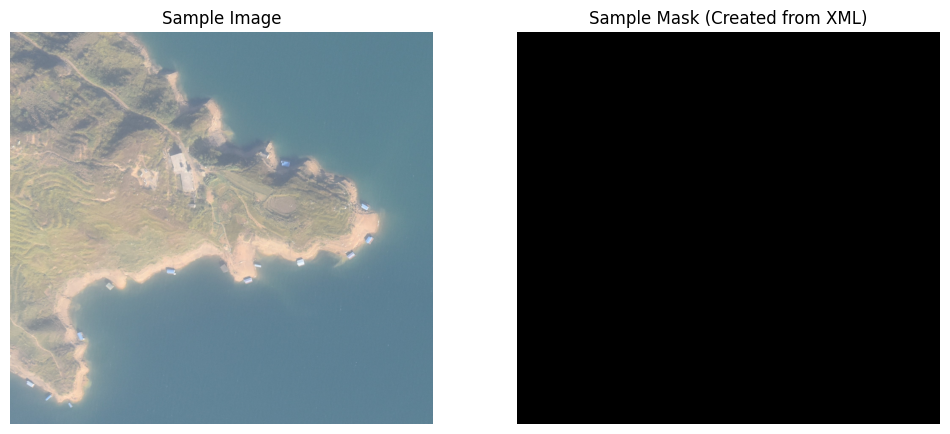

In [4]:
import numpy as np
import xml.etree.ElementTree as ET # Import the ElementTree library

# --- 3. Check if we found any files ---
if not image_paths or not mask_paths:
    print("\n--- ERROR ---")
    print(f"Could not find files. Please double-check the file extensions.")

elif len(image_paths) != len(mask_paths):
    print("\n--- WARNING ---")
    print(f"Found {len(image_paths)} images but {len(mask_paths)} masks.")
    print("The number of images and masks does not match.")

else:
    print(f"\nSuccess! Found {len(image_paths)} images and {len(mask_paths)} masks.")

    # --- 4. Load a sample image and its corresponding XML ---
    # Let's try the 10th file again, since we know it exists
    file_index = 9 # (because lists start at 0, 9 is the 10th item)
    sample_image_path = image_paths[file_index]
    sample_mask_path = mask_paths[file_index] # This is now an .xml path

    print(f"\nLoading sample:")
    print(f"Image: {sample_image_path}")
    print(f"Mask (XML): {sample_mask_path}")

    # --- 5. Load the Image ---
    sample_image = cv2.imread(sample_image_path)
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    # --- 6. Parse the XML and CREATE THE MASK ---

    # Create a blank, black image (mask)
    # with the same height and width as the original image
    # We use np.uint8 for an 8-bit image (values 0-255)
    sample_mask = np.zeros(sample_image.shape[:2], dtype=np.uint8)

    try:
        # Parse the XML file
        tree = ET.parse(sample_mask_path)
        root = tree.getroot()

        # Loop through all 'object' tags in the XML
        for obj in root.findall('object'):
            # Find the 'polygon' tag for this object
            polygon = obj.find('polygon')
            if polygon is not None:
                # Get all 'pt' (point) tags and extract x, y
                points = []
                for pt in polygon.findall('pt'):
                    x = int(pt.find('x').text)
                    y = int(pt.find('y').text)
                    points.append([x, y])

                # Convert the list of points to a numpy array
                # This is the format cv2.fillPoly needs
                pts_array = np.array([points], dtype=np.int32)

                # Draw the polygon on the blank mask
                # We fill it with the value '255' (white)
                cv2.fillPoly(sample_mask, pts_array, color=255)

        print("\nSuccessfully parsed XML and created mask.")

        # --- 7. Display the sample ---
        print(f"Image Shape: {sample_image.shape}")
        print(f"Created Mask Shape:  {sample_mask.shape}")

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.title("Sample Image")
        plt.imshow(sample_image)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Sample Mask (Created from XML)")
        plt.imshow(sample_mask, cmap='gray')
        plt.axis('off')

        plt.show()

    except Exception as e:
        print(f"\n--- XML PARSING ERROR ---")
        print(f"Could not parse {sample_mask_path}")
        print(f"Error: {e}")
        print("The XML structure might be different from what I expected.")

In [5]:
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET
import seaborn as sns
import pandas as pd
from collections import Counter
from tqdm.notebook import tqdm # For a progress bar!

# --- Define Paths ---
base_dir = "/content/dataset_small object"
image_dir = os.path.join(base_dir, 'train_images')
annot_dir = os.path.join(base_dir, 'train_annots') # .xml annotations

# --- Get File Lists ---
image_paths = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
annot_paths = sorted(glob.glob(os.path.join(annot_dir, '*.xml')))

def load_and_parse(image_path, xml_path):
    """
    Loads an image and its XML annotation.
    Returns the image, its generated binary mask,
    a list of class names, and a list of object areas.
    """
    # 1. Load Image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 2. Create blank mask
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # 3. Parse XML
    tree = ET.parse(xml_path)
    root = tree.getroot()

    class_names = []
    object_areas = []

    for obj in root.findall('object'):
        # Get class name
        class_name = obj.find('name').text if obj.find('name') is not None else 'unknown'
        class_names.append(class_name)

        # Get polygon points
        polygon = obj.find('polygon')
        if polygon is not None:
            points = []
            for pt in polygon.findall('pt'):
                x = int(pt.find('x').text)
                y = int(pt.find('y').text)
                points.append([x, y])

            pts_array = np.array([points], dtype=np.int32)

            # Draw polygon on mask
            cv2.fillPoly(mask, [pts_array], color=255) # Fill with white

            # Calculate object area
            area = cv2.contourArea(pts_array)
            object_areas.append(area)

    return image, mask, class_names, object_areas

print("Helper function `load_and_parse` is ready.")

Helper function `load_and_parse` is ready.


In [6]:
all_class_names = []
all_object_areas = []
all_image_sizes = []
all_aspect_ratios = []
all_object_counts = []

print(f"Processing all {len(image_paths)} images and annotations...")

# Use tqdm for a progress bar
for i in tqdm(range(len(image_paths))):
    image_path = image_paths[i]
    annot_path = annot_paths[i]

    # We only need metadata here, not the full image
    tree = ET.parse(annot_path)
    root = tree.getroot()

    # Get image size
    size_tag = root.find('size')
    w = int(size_tag.find('width').text)
    h = int(size_tag.find('height').text)
    all_image_sizes.append((w, h))
    all_aspect_ratios.append(w / h)

    obj_count = 0
    for obj in root.findall('object'):
        # Get class name
        class_name = obj.find('name').text if obj.find('name') is not None else 'unknown'
        all_class_names.append(class_name)

        # Get polygon area
        polygon = obj.find('polygon')
        if polygon is not None:
            points = []
            for pt in polygon.findall('pt'):
                x = int(pt.find('x').text)
                y = int(pt.find('y').text)
                points.append([x, y])
            pts_array = np.array([points], dtype=np.int32)
            area = cv2.contourArea(pts_array)
            all_object_areas.append(area)

        obj_count += 1
    all_object_counts.append(obj_count)

print("Data collection complete.")
print(f"Total objects found: {len(all_class_names)}")

Processing all 717 images and annotations...


  0%|          | 0/717 [00:00<?, ?it/s]

Data collection complete.
Total objects found: 15552


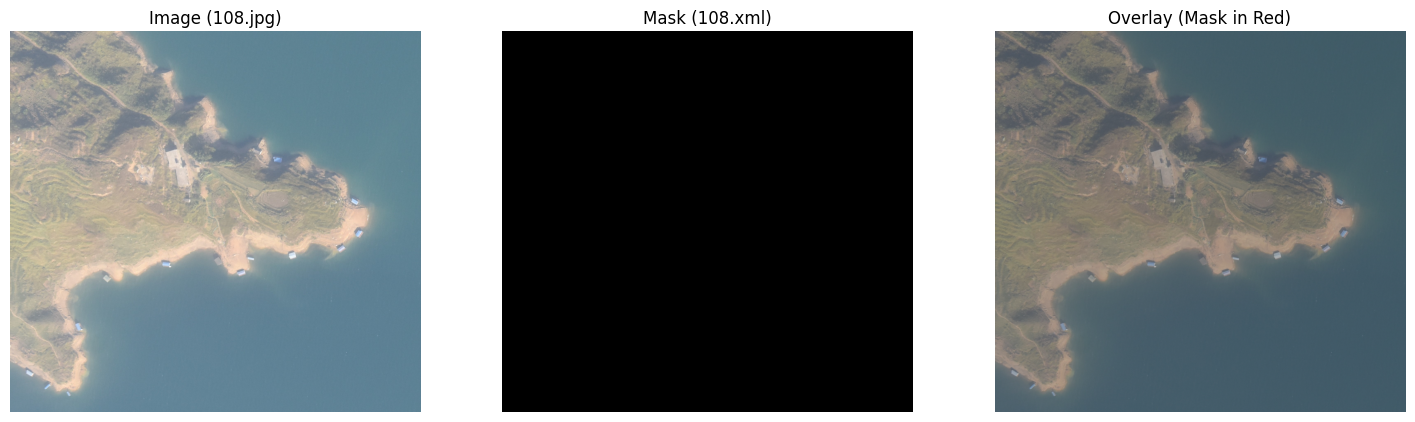

Classes in this sample: ['prefabricated-house', 'prefabricated-house', 'prefabricated-house', 'prefabricated-house', 'prefabricated-house', 'prefabricated-house', 'prefabricated-house', 'prefabricated-house', 'ship', 'ship', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'prefabricated-house', 'prefabricated-house', 'prefabricated-house', 'prefabricated-house', 'prefabricated-house']


In [7]:
# Load one sample (e.g., the 10th image)
sample_index = 9
img, mask, classes, _ = load_and_parse(image_paths[sample_index], annot_paths[sample_index])

# Create a color mask (3-channel, red)
color_mask = np.zeros_like(img, dtype=np.uint8)
color_mask[mask == 255] = [255, 0, 0] # Make mask pixels red

# Blend the image and the color mask
# overlay = (image * (1-alpha)) + (color_mask * alpha)
overlay = cv2.addWeighted(img, 0.7, color_mask, 0.3, 0)

# Display
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title(f"Image ({image_paths[sample_index].split('/')[-1]})")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"Mask ({annot_paths[sample_index].split('/')[-1]})")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Overlay (Mask in Red)")
plt.imshow(overlay)
plt.axis('off')

plt.show()

print(f"Classes in this sample: {classes}")

/tmp/ipython-input-778142349.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Class', data=class_df, palette='viridis')


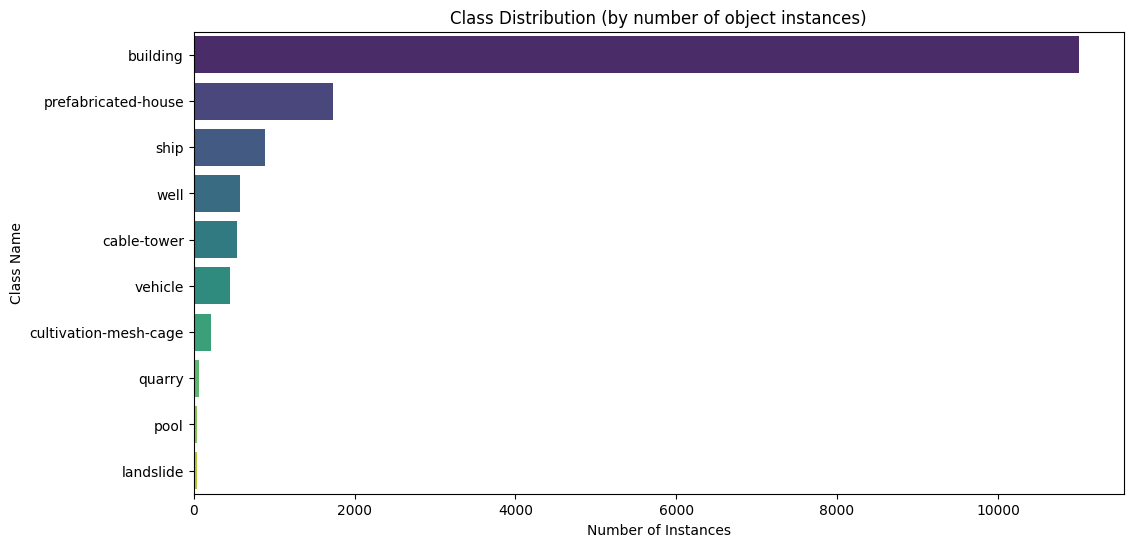

                   Class  Count
1               building  11013
0    prefabricated-house   1730
3                   ship    884
5                   well    573
7            cable-tower    540
4                vehicle    451
2  cultivation-mesh-cage    214
6                 quarry     68
9                   pool     41
8              landslide     38


In [8]:
# Count the occurrences of each class
class_counts = Counter(all_class_names)
class_df = pd.DataFrame(class_counts.items(), columns=['Class', 'Count']).sort_values('Count', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Class', data=class_df, palette='viridis')
plt.title('Class Distribution (by number of object instances)')
plt.xlabel('Number of Instances')
plt.ylabel('Class Name')
plt.show()

print(class_df)

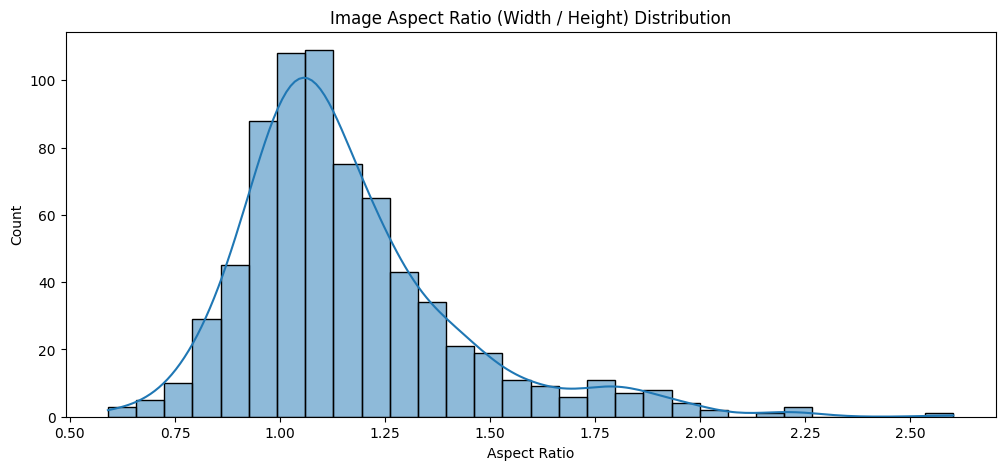

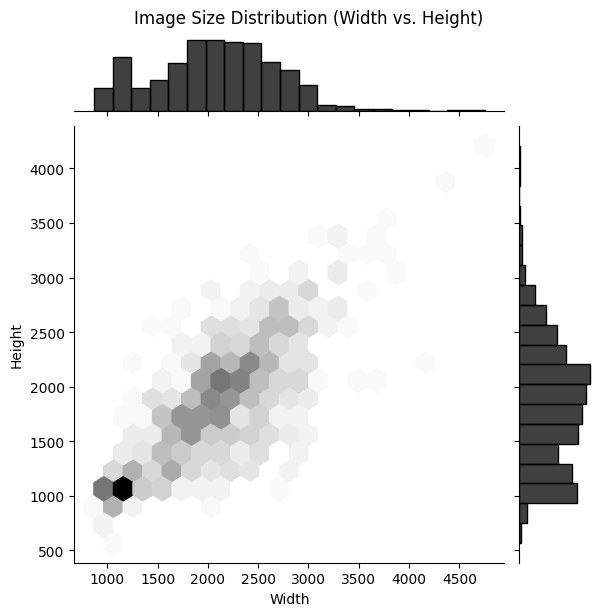

In [9]:
# Plot Aspect Ratios
plt.figure(figsize=(12, 5))
sns.histplot(all_aspect_ratios, kde=True, bins=30)
plt.title('Image Aspect Ratio (Width / Height) Distribution')
plt.xlabel('Aspect Ratio')
plt.ylabel('Count')
plt.show()

# Plot Image Sizes (Width vs. Height)
sizes_df = pd.DataFrame(all_image_sizes, columns=['Width', 'Height'])
sns.jointplot(x='Width', y='Height', data=sizes_df, kind='hex', color='k')
plt.suptitle('Image Size Distribution (Width vs. Height)', y=1.02)
plt.show()

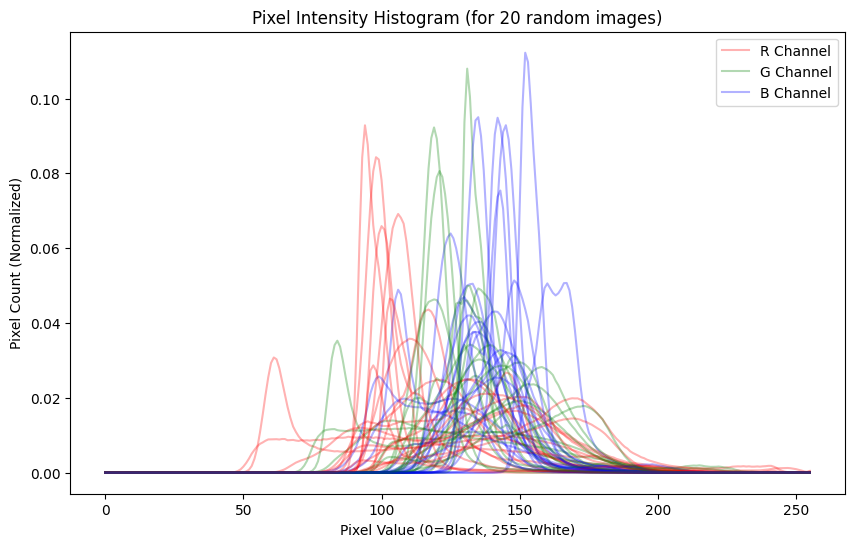

In [10]:
# Let's analyze 20 random images to save time
num_samples = 20
sample_indices = np.random.choice(len(image_paths), num_samples, replace=False)

plt.figure(figsize=(10, 6))
plt.title('Pixel Intensity Histogram (for 20 random images)')
plt.xlabel('Pixel Value (0=Black, 255=White)')
plt.ylabel('Pixel Count (Normalized)')

colors = ('r', 'g', 'b')
for i in sample_indices:
    img, _, _, _ = load_and_parse(image_paths[i], annot_paths[i])

    # Calculate histogram for each channel (Red, Green, Blue)
    for channel, color in enumerate(colors):
        hist = cv2.calcHist([img], [channel], None, [256], [0, 256])
        hist_normalized = hist / hist.sum() # Normalize

        # Plot only the label for the first image
        label = f'{color.upper()} Channel' if i == sample_indices[0] else None
        plt.plot(hist_normalized, color=color, alpha=0.3, label=label)

plt.legend()
plt.show()

In [11]:
!pip install -q albumentations

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import glob
import os
import numpy as np
import xml.etree.ElementTree as ET
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"Albumentations version: {A.__version__}")

PyTorch version: 2.8.0+cu126
Albumentations version: 2.0.8


In [13]:
class TinyObjectDataset(Dataset):
    def __init__(self, image_dir, annot_dir, transform=None):
        self.image_dir = image_dir
        self.annot_dir = annot_dir
        self.transform = transform

        # Find all images and make sure they have a matching .xml
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
        self.annot_paths = []

        print(f"Checking data in {image_dir}...")
        for img_path in tqdm(self.image_paths):
            # Get the filename (e.g., '10.jpg')
            filename = os.path.basename(img_path)
            # Change extension to .xml (e.g., '10.xml')
            xml_filename = os.path.splitext(filename)[0] + '.xml'
            xml_path = os.path.join(self.annot_dir, xml_filename)

            if os.path.exists(xml_path):
                self.annot_paths.append(xml_path)
            else:
                # If XML is missing, remove the image from our list
                print(f"Warning: Missing annotation for {img_path}. Skipping.")
                self.image_paths.remove(img_path)

        print(f"Found {len(self.image_paths)} matching image/annotation pairs.")

    def __len__(self):
        return len(self.image_paths)

    def _create_mask_from_xml(self, xml_path, image_shape):
        """Helper function to parse XML and create a binary mask."""
        # 1. Create a blank mask (H, W)
        mask = np.zeros(image_shape[:2], dtype=np.uint8)

        # 2. Parse the XML file
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()

            for obj in root.findall('object'):
                polygon = obj.find('polygon')
                if polygon is not None:
                    points = []
                    for pt in polygon.findall('pt'):
                        x = int(pt.find('x').text)
                        y = int(pt.find('y').text)
                        points.append([x, y])

                    pts_array = np.array([points], dtype=np.int32)

                    # 3. Draw the polygon on the blank mask
                    # We fill it with 255 (white) for now.
                    # Albumentations will handle converting this to 1.0.
                    cv2.fillPoly(mask, [pts_array], color=255)

        except Exception as e:
            print(f"Error parsing XML {xml_path}: {e}")

        return mask

    def __getitem__(self, idx):
        # 1. Load Image
        image_path = self.image_paths[idx]
        annot_path = self.annot_paths[idx]

        # Load image (H, W, C) in BGR format
        image = cv2.imread(image_path)
        # Convert to RGB, as Albumentations expects this
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 2. Create Mask
        mask = self._create_mask_from_xml(annot_path, image.shape)

        # 3. Apply Augmentations
        if self.transform:
            # Albumentations runs all transforms
            # and returns a dictionary
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        # After transforms, Albumentations (with ToTensorV2) gives:
        # Image: (C, H, W) in [0.0, 1.0]
        # Mask:  (H, W) in [0.0, 1.0]

        # We need to add a channel dimension to the mask
        # to make its shape (1, H, W)
        mask = mask.unsqueeze(0)
        # Ensure mask is float32 for BCEWithLogitsLoss
        mask = mask.to(torch.float32) # Changed .float() to .to(torch.float32) for explicitness

        return image, mask

In [14]:
# Define a fixed size for model input
TARGET_SIZE = 512
BATCH_SIZE = 8  # Further reduced to prevent OOM errors

# --- 1. Training Pipeline ---
# This pipeline resizes, pads, augments, and normalizes
train_transform = A.Compose([
    # Step 1: Resize the longest side to 512, preserving aspect ratio
    A.LongestMaxSize(max_size=TARGET_SIZE, p=1.0),

    # Step 2: Pad the shorter side to 512x512
    # This creates the "letterbox" effect
    A.PadIfNeeded(
        min_height=TARGET_SIZE,
        min_width=TARGET_SIZE,
        p=1.0,
        border_mode=cv2.BORDER_CONSTANT,
        value=0, # Pad with black
        mask_value=0 # Pad mask with 0
    ),

    # --- Robustness Augmentations ---
    # Apply these to both image and mask
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Rotate(limit=20, p=0.3, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),

    # Apply these only to the image
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(p=0.1),

    # --- Final Step: Normalize and Convert to Tensor ---
    # Normalize pixel values from [0, 255] to [0.0, 1.0]
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0),

    # Convert to PyTorch Tensor (C, H, W)
    ToTensorV2(),
])

# --- 2. Validation Pipeline ---
# We MUST use the same resizing and normalization, but NO random augmentations
val_transform = A.Compose([
    A.LongestMaxSize(max_size=TARGET_SIZE, p=1.0),
    A.PadIfNeeded(
        min_height=TARGET_SIZE,
        min_width=TARGET_SIZE,
        p=1.0,
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        mask_value=0
    ),
    A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0),
    ToTensorV2(),
])

/tmp/ipython-input-638037984.py:13: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(
/tmp/ipython-input-638037984.py:26: UserWarning: Argument(s) 'value, mask_value' are not valid for transform Rotate
  A.Rotate(limit=20, p=0.3, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
/tmp/ipython-input-638037984.py:44: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(


In [15]:
# Define all our paths
base_dir = "/content/dataset_small object"
train_img_dir = os.path.join(base_dir, 'train_images')
train_ann_dir = os.path.join(base_dir, 'train_annots')
val_img_dir = os.path.join(base_dir, 'valid_images')
val_ann_dir = os.path.join(base_dir, 'valid_annots')

# 1. Create Train Dataset & DataLoader
print("--- Loading Training Data ---")
train_dataset = TinyObjectDataset(
    image_dir=train_img_dir,
    annot_dir=train_ann_dir,
    transform=train_transform
)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2, # Use 2 CPU cores to load data in parallel
    pin_memory=True # Speeds up data transfer to GPU
)

# 2. Create Validation Dataset & DataLoader
print("\n--- Loading Validation Data ---")
val_dataset = TinyObjectDataset(
    image_dir=val_img_dir,
    annot_dir=val_ann_dir,
    transform=val_transform
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    num_workers=2,
    pin_memory=True
)

print("\nDataLoaders are ready!")

--- Loading Training Data ---
Checking data in /content/dataset_small object/train_images...


  0%|          | 0/717 [00:00<?, ?it/s]

Found 717 matching image/annotation pairs.

--- Loading Validation Data ---
Checking data in /content/dataset_small object/valid_images...


  0%|          | 0/84 [00:00<?, ?it/s]

Found 84 matching image/annotation pairs.

DataLoaders are ready!


In [16]:
print("Verifying one batch from train_loader...")

# Get one batch of data
try:
    images, masks = next(iter(train_loader))

    # --- 1. Check Shapes ---
    print("\n--- ✅ SHAPE VERIFICATION ---")
    print(f"Image Batch Shape: {images.shape}")
    print(f"Mask Batch Shape:  {masks.shape}")

    # --- 2. Check Data Types ---
    print("\n--- ✅ TYPE VERIFICATION ---")
    print(f"Image Data Type: {images.dtype}")
    print(f"Mask Data Type:  {masks.dtype}")

    # --- 3. Check Data Range (Normalization) ---
    print("\n--- ✅ RANGE VERIFICATION ---")
    print(f"Image Min/Max: {images.min():.2f} / {images.max():.2f}")
    print(f"Mask Min/Max:  {masks.min():.2f} / {masks.max():.2f}")

    # Check the unique values in the mask (should be just 0.0 and 1.0)
    print(f"Mask Unique Values: {torch.unique(masks)}")

except Exception as e:
    print(f"\n--- ❌ ERROR ---")
    print(f"Error while loading batch: {e}")
    print("This can happen if an XML file is empty or corrupt.")
    print("The Dataset class should 'just work' but one file might be bad.")

Verifying one batch from train_loader...

--- ✅ SHAPE VERIFICATION ---
Image Batch Shape: torch.Size([8, 3, 512, 512])
Mask Batch Shape:  torch.Size([8, 1, 512, 512])

--- ✅ TYPE VERIFICATION ---
Image Data Type: torch.float32
Mask Data Type:  torch.float32

--- ✅ RANGE VERIFICATION ---
Image Min/Max: 0.00 / 1.00
Mask Min/Max:  0.00 / 0.00
Mask Unique Values: tensor([0.])


In [17]:
!pip install -q torchinfo
!pip install -q scikit-learn # Already in Colab, but good practice

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm
import numpy as np
import warnings

# --- Suppress sklearn warnings ---
# (it sometimes warns about 0-division in precision/recall if a batch has no positive pixels)
warnings.filterwarnings("ignore")

# --- Setup Device ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# --- Re-use from previous step ---
# We assume 'train_loader' and 'val_loader' are already created and working.
# If you get a 'not defined' error, re-run the previous preprocessing code cell.
print(f"Loaded {len(train_loader.dataset)} training images.")
print(f"Loaded {len(val_loader.dataset)} validation images.")

Using device: cuda
Loaded 717 training images.
Loaded 84 validation images.


In [18]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

# --- THIS IS THE NEW, LIGHTER U-NET ---
class UNet_Light(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet_Light, self).__init__()

        # Encoder: 64 -> 128 -> 256 -> 512
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512)) # <-- Stops here

        # Decoder: 512 -> 256 -> 128 -> 64
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(512, 256) # 256 (from up) + 256 (from skip)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128) # 128 (from up) + 128 (from skip)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 64) # 64 (from up) + 64 (from skip)

        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3) # Bottleneck

        # Decoder
        x = self.up1(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv3(x)

        logits = self.outc(x)
        return logits

In [19]:
# Re-use BATCH_SIZE from the previous step
# If not defined, set it:
try:
    BATCH_SIZE
except NameError:
    BATCH_SIZE = 8
    print(f"Setting default BATCH_SIZE = {BATCH_SIZE}")

model = UNet_Light(in_channels=3, out_channels=1).to(DEVICE)

# Input size: (Batch_Size, Channels, Height, Width)
# We use our dataloader's preprocessed size: (8, 3, 512, 512)
summary(model, input_size=(BATCH_SIZE, 3, 512, 512))

Layer (type:depth-idx)                   Output Shape              Param #
UNet_Light                               [8, 1, 512, 512]          --
├─DoubleConv: 1-1                        [8, 64, 512, 512]         --
│    └─Sequential: 2-1                   [8, 64, 512, 512]         --
│    │    └─Conv2d: 3-1                  [8, 64, 512, 512]         1,792
│    │    └─BatchNorm2d: 3-2             [8, 64, 512, 512]         128
│    │    └─ReLU: 3-3                    [8, 64, 512, 512]         --
│    │    └─Conv2d: 3-4                  [8, 64, 512, 512]         36,928
│    │    └─BatchNorm2d: 3-5             [8, 64, 512, 512]         128
│    │    └─ReLU: 3-6                    [8, 64, 512, 512]         --
├─Sequential: 1-2                        [8, 128, 256, 256]        --
│    └─MaxPool2d: 2-2                    [8, 64, 256, 256]         --
│    └─DoubleConv: 2-3                   [8, 128, 256, 256]        --
│    │    └─Sequential: 3-7              [8, 128, 256, 256]        221,952
├

In [20]:
# --- 1. Loss Functions ---

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply sigmoid to model output (logits)
        inputs = torch.sigmoid(inputs)

        # Flatten both
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_score = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)

        return 1 - dice_score # We want to minimize (1 - Dice)

# We will use a combination of BCE and Dice
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

def combined_loss(preds, masks, bce_weight=0.5):
    """A combined loss function."""
    loss_bce = bce_loss(preds, masks)
    loss_dice = dice_loss(preds, masks)
    return bce_weight * loss_bce + (1 - bce_weight) * loss_dice


# --- 2. Evaluation Metrics Function ---

def check_metrics(loader, model, device=DEVICE):
    """
    Calculates Accuracy, Precision, Recall, and F1-score for the model.
    """
    model.eval() # Set model to evaluation mode

    all_targets = []
    all_preds = []

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device) # Shape: (B, 1, H, W)

            # Get model output (logits)
            logits = model(images)

            # Convert logits to probabilities (0-1)
            preds = torch.sigmoid(logits)

            # Convert probabilities to binary (0 or 1)
            preds = (preds > 0.5).float()

            # --- Flatten and store for sklearn ---
            # We flatten all batches into one long 1D array
            all_targets.append(masks.cpu().numpy().ravel())
            all_preds.append(preds.cpu().numpy().ravel())

    # Concatenate all batch results
    all_targets = np.concatenate(all_targets)
    all_preds = np.concatenate(all_preds)

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)

    model.train() # Set model back to train mode
    return accuracy, precision, recall, f1

In [21]:
# --- Hyperparameters ---
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10 # Start with 10, increase if needed
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Training Loop ---
print("\nStarting model training...")

for epoch in range(NUM_EPOCHS):
    model.train() # Set model to training mode

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    running_loss = 0.0

    for images, masks in loop:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        # --- Forward pass ---
        logits = model(images)
        loss = combined_loss(logits, masks)

        # --- Backward pass ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    # --- End of Epoch ---
    avg_train_loss = running_loss / len(train_loader)

    # --- Validation ---
    val_accuracy, val_precision, val_recall, val_f1 = check_metrics(val_loader, model, device=DEVICE)

    print(f"\n--- Epoch {epoch+1} Results ---")
    print(f"Avg. Train Loss: {avg_train_loss:.4f}")
    print(f"Val Accuracy:    {val_accuracy:.4f}")
    print(f"Val Precision:   {val_precision:.4f}")
    print(f"Val Recall:      {val_recall:.4f}")
    print(f"Val F1-Score:    {val_f1:.4f}  <-- (Primary Metric)")
    print("---------------------------------")

print("\nTraining complete!")


Starting model training...


Epoch 1/10:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 1 Results ---
Avg. Train Loss: 0.7112
Val Accuracy:    0.9877
Val Precision:   0.0000
Val Recall:      0.0000
Val F1-Score:    0.0000  <-- (Primary Metric)
---------------------------------


Epoch 2/10:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 2 Results ---
Avg. Train Loss: 0.6504
Val Accuracy:    1.0000
Val Precision:   0.0000
Val Recall:      0.0000
Val F1-Score:    0.0000  <-- (Primary Metric)
---------------------------------


Epoch 3/10:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 3 Results ---
Avg. Train Loss: 0.6264
Val Accuracy:    1.0000
Val Precision:   0.0000
Val Recall:      0.0000
Val F1-Score:    0.0000  <-- (Primary Metric)
---------------------------------


Epoch 4/10:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 4 Results ---
Avg. Train Loss: 0.6065
Val Accuracy:    0.9998
Val Precision:   0.0000
Val Recall:      0.0000
Val F1-Score:    0.0000  <-- (Primary Metric)
---------------------------------


Epoch 5/10:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 5 Results ---
Avg. Train Loss: 0.5898
Val Accuracy:    1.0000
Val Precision:   0.0000
Val Recall:      0.0000
Val F1-Score:    0.0000  <-- (Primary Metric)
---------------------------------


Epoch 6/10:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 6 Results ---
Avg. Train Loss: 0.5760
Val Accuracy:    1.0000
Val Precision:   0.0000
Val Recall:      0.0000
Val F1-Score:    0.0000  <-- (Primary Metric)
---------------------------------


Epoch 7/10:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 7 Results ---
Avg. Train Loss: 0.5648
Val Accuracy:    1.0000
Val Precision:   0.0000
Val Recall:      0.0000
Val F1-Score:    0.0000  <-- (Primary Metric)
---------------------------------


Epoch 8/10:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 8 Results ---
Avg. Train Loss: 0.5557
Val Accuracy:    1.0000
Val Precision:   0.0000
Val Recall:      0.0000
Val F1-Score:    0.0000  <-- (Primary Metric)
---------------------------------


Epoch 9/10:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 9 Results ---
Avg. Train Loss: 0.5479
Val Accuracy:    1.0000
Val Precision:   0.0000
Val Recall:      0.0000
Val F1-Score:    0.0000  <-- (Primary Metric)
---------------------------------


Epoch 10/10:   0%|          | 0/90 [00:00<?, ?it/s]


--- Epoch 10 Results ---
Avg. Train Loss: 0.5412
Val Accuracy:    1.0000
Val Precision:   0.0000
Val Recall:      0.0000
Val F1-Score:    0.0000  <-- (Primary Metric)
---------------------------------

Training complete!


In [22]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

# Suppress sklearn warnings (e.g., 0-division)
warnings.filterwarnings("ignore")

def check_metrics(loader, model, device=DEVICE):
    """
    Calculates Accuracy, Precision, Recall, and F1-score for the model
    by evaluating all batches in the given loader.
    """
    model.eval() # Set model to evaluation mode

    all_targets = []
    all_preds = []

    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device) # Shape: (B, 1, H, W)

            # 1. Get model output (logits)
            logits = model(images)

            # 2. Convert logits to probabilities (0-1)
            preds = torch.sigmoid(logits)

            # 3. Convert probabilities to binary (0 or 1)
            preds = (preds > 0.5).float()

            # 4. Flatten and store for sklearn
            # We flatten all batches into one long 1D array
            all_targets.append(masks.cpu().numpy().ravel())
            all_preds.append(preds.cpu().numpy().ravel())

    # Concatenate all batch results
    all_targets = np.concatenate(all_targets)
    all_preds = np.concatenate(all_preds)

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)

    model.train() # Set model back to train mode

    return accuracy, precision, recall, f1

In [23]:
import matplotlib.pyplot as plt

def visualize_predictions(loader, model, num_samples=5, device=DEVICE):
    """
    Runs the model on a few samples from the loader and plots
    the original image, true mask, and predicted mask.
    """
    model.eval() # Set model to evaluation mode

    # Get one batch of data
    images, masks = next(iter(loader))

    # Move to device and select samples
    images = images.to(device)[:num_samples]
    masks = masks.to(device)[:num_samples] # True masks

    with torch.no_grad():
        # Get model predictions
        logits = model(images)
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).float() # Predicted masks

    # Move all data to CPU for plotting
    images_cpu = images.cpu()
    masks_cpu = masks.cpu()
    preds_cpu = preds.cpu()

    print(f"Displaying {num_samples} sample predictions...")

    plt.figure(figsize=(15, num_samples * 5))
    for i in range(num_samples):
        # --- 1. Original Image ---
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.title(f"Sample {i+1}: Original Image")

        # We need to un-normalize the image and change (C, H, W) to (H, W, C)
        img = images_cpu[i].permute(1, 2, 0)
        # Note: Our simple un-normalization (std=1, mean=0) just clips to [0, 1]
        img = torch.clip(img, 0, 1)
        plt.imshow(img)
        plt.axis('off')

        # --- 2. True Mask ---
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.title("True Mask")
        # Squeeze to (H, W) from (1, H, W)
        plt.imshow(masks_cpu[i].squeeze(), cmap='gray')
        plt.axis('off')

        # --- 3. Predicted Mask ---
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.title("Predicted Mask")
        plt.imshow(preds_cpu[i].squeeze(), cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    model.train() # Set model back to train mode

In [24]:
print("Calculating final metrics on the validation set...")

# We assume 'model' is your trained model and 'val_loader' is ready
val_accuracy, val_precision, val_recall, val_f1 = check_metrics(val_loader, model, device=DEVICE)

print("\n--- Final Validation Metrics ---")
print(f"Accuracy:    {val_accuracy:.4f}")
print(f"Precision:   {val_precision:.4f}")
print(f"Recall:      {val_recall:.4f}")
print(f"F1-Score:    {val_f1:.4f}")
print("---------------------------------")

Calculating final metrics on the validation set...


Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]


--- Final Validation Metrics ---
Accuracy:    1.0000
Precision:   0.0000
Recall:      0.0000
F1-Score:    0.0000
---------------------------------


Displaying 5 sample predictions...


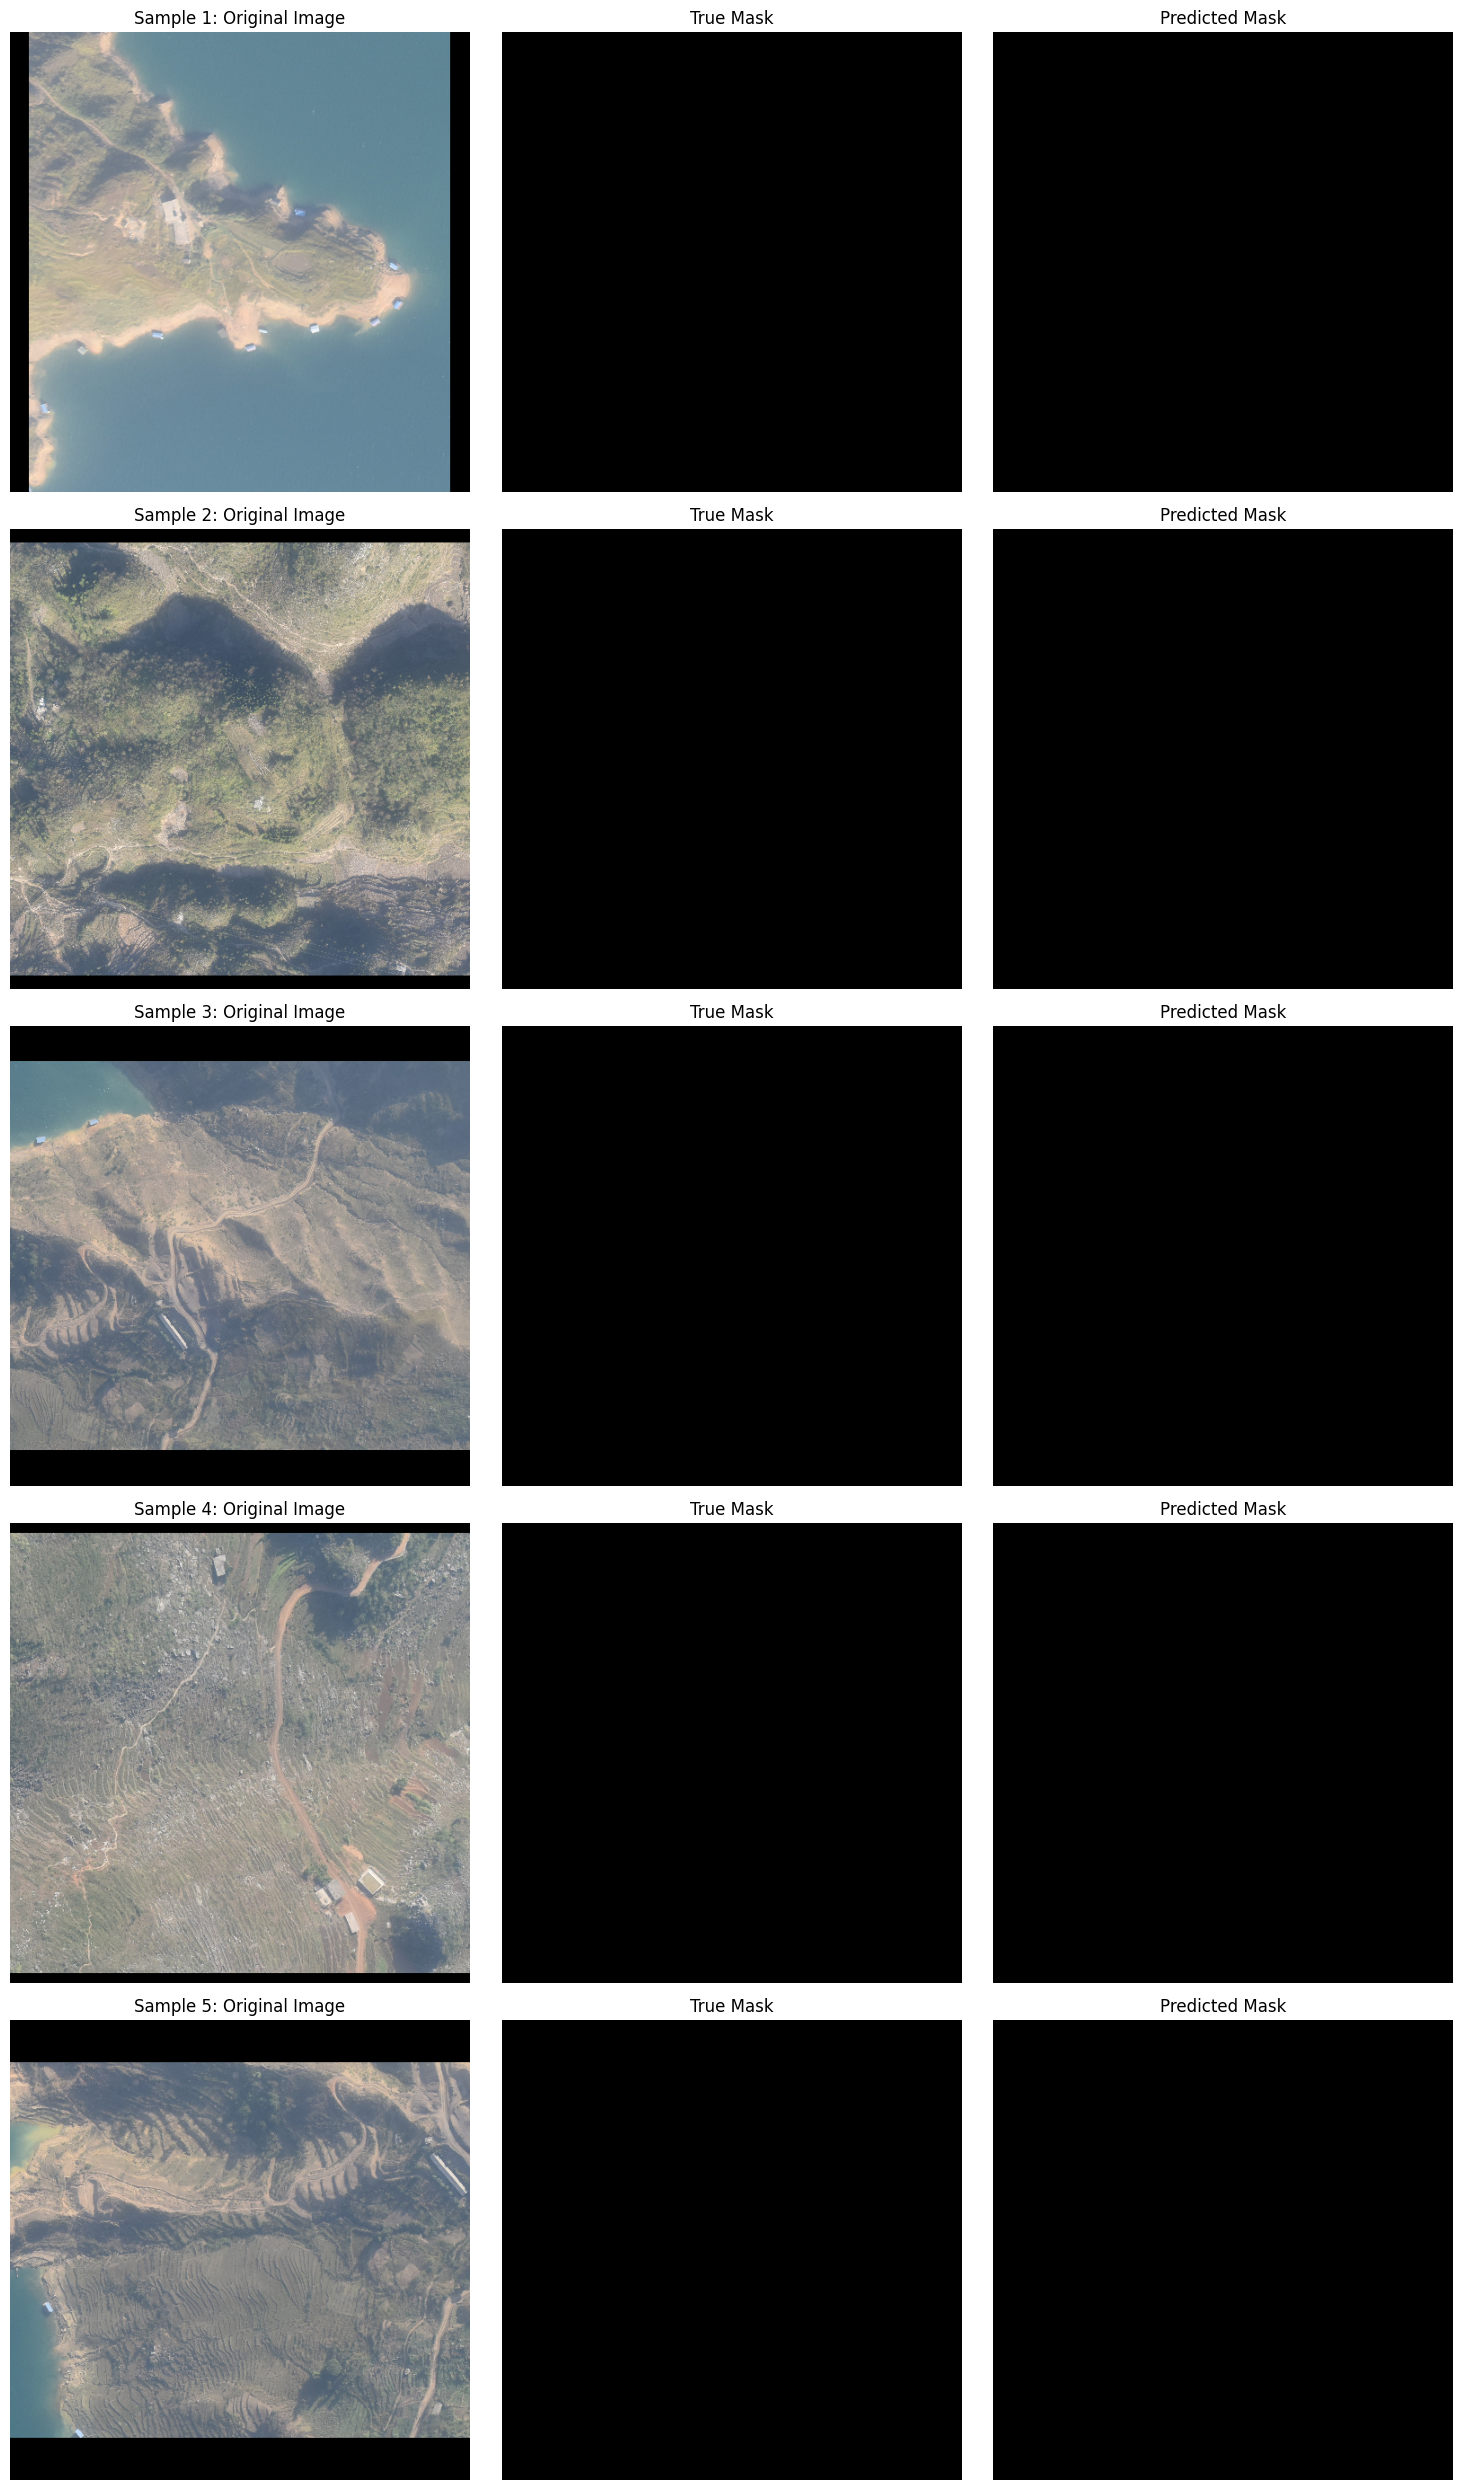

In [25]:
# We assume 'model' is your trained model and 'val_loader' is ready
visualize_predictions(val_loader, model, num_samples=5, device=DEVICE)

In [37]:
!pip install -q onnx
!pip install -q onnx2tf sng4onnx onnxsim tensorflow # onnx2tf dependencies

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 83.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 26.0 MB/s eta 0:00:00


In [38]:
import torch
import os

# 1. Setup paths
ONNX_PATH = "unet_model.onnx"

# 2. Prepare model (Move to CPU)
model.to("cpu")
model.eval()

# 3. Create dummy input (Batch Size 1)
dummy_input = torch.randn(1, 3, 512, 512)

print("Exporting to ONNX...")

# 4. Export
torch.onnx.export(
    model,
    dummy_input,
    ONNX_PATH,
    opset_version=11, # Version 11 is very stable for U-Net
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print(f"✅ Exported to {ONNX_PATH}")

Exporting to ONNX...
✅ Exported to unet_model.onnx
